In [142]:
# импорт библиотек
import numpy as np # для матричных вычислений
import pandas as pd # для анализа и предобработки данных
import matplotlib.pyplot as plt # для визуализации
import seaborn as sns # для визуализации

from sklearn import linear_model # линейные модели
from sklearn import metrics # метрики
from sklearn import preprocessing # предобработка
from sklearn.model_selection import train_test_split # сплитование выборки
%matplotlib inline
plt.style.use('seaborn')

C:\Users\Lida\AppData\Local\Temp\ipykernel_10540\2715922372.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Повторим, как организуется процесс разработки DS-проектов согласно методологии CRISP-DM.

Этапы модели CRISP-DM:
1. Анализ требований (общаемся с заказщиком, выявляем требования, выявляем метрику, по которой будем считать качество нашей модели, составляем план проекта, составляем техничесткое задание и тд)
2. Исследование данных (получаем данные от заказщика, выявляем зависимости)
3. Подготовка данных
4. Моделирование (используем одну или несколько моделей)
5. Оценка модели (при помощи ML-метрик или бизнес-метрик пытаемся оценить качество модели, показываем заказщику, при необходимости переходим на новую итерацию и этапы повторяются вновь)
6. Внедрение

Прочитаем данные:

In [143]:
data = pd.read_csv('data/insurance.zip')
data.head(3)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620


Итак, набор данных содержит следующие столбцы:

* *age* — возраст основного бенефициара;
* *sex* — пол страхового подрядчика;
* *bmi* — индекс массы тела ($кг/м^2$), в идеале — от 18.5 до 24.9;
* *children* — количество детей, охваченных медицинской страховкой;
* *smoker* — является ли человек курящим;
* *region* — жилой район США (северо-восток, юго-восток, северо-запад, юго-запад);
* *charges* (целевой признак) — индивидуальные медицинские расходы, оплачиваемые медицинской страховкой.

Размер таблицы:

In [144]:
print(data.shape)

(1338, 7)


Выведем информацию о пропусках, так как наличие пропусков не позволит нам построить модель линейной регрессии:

In [145]:
display(data.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Пропуски в таблице отсутствуют.

Посмотрим на типы данных:

In [146]:
display(data.dtypes)

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

Наши данные содержат несколько типов признаков:

* *age, bmi, children* — числовые признаки;
* *sex, smoker* — бинарные категориальные переменные (две категории);
* *region* — множественные категориальные переменные (несколько категорий);
* *charges* — числовой целевой признак.

Выводим описательные статистики для числовых и категориальных признаков

In [147]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Прежде чем приступать к этапу подготовки данных для модели, вы можете произвести небольшое исследование зависимостей в данных, например построить следующие графики и диаграммы:

* гистограммы/коробчатые диаграммы числовых признаков;
* столбчатые диаграммы медианных медицинских расходов в зависимости от категориальных признаков;
* диаграммы рассеяния зависимости целевого признака от других числовых в разрезе категориальных (обратите особенное внимание на зависимость медицинских расходов от признака курения).

In [148]:
# Создаем копию данных для облегчения работы с изменениями в таблице
temp_data = data.copy()

In [149]:
# выделяем имена числовых признаков в виде списка для удобства дальнейшей работы
types = temp_data.dtypes
num_features = list(types[(types != 'object')].index)
num_features

['age', 'bmi', 'children', 'charges']

Для каждого числового признака построим гистограмму признаки и диаграмму рассеяния, иллюстрирующую зависимость целевого признака от каждого из факторов. Дополнительно поверх диаграммы рассеяния построим уравнение линейной регрессии. 

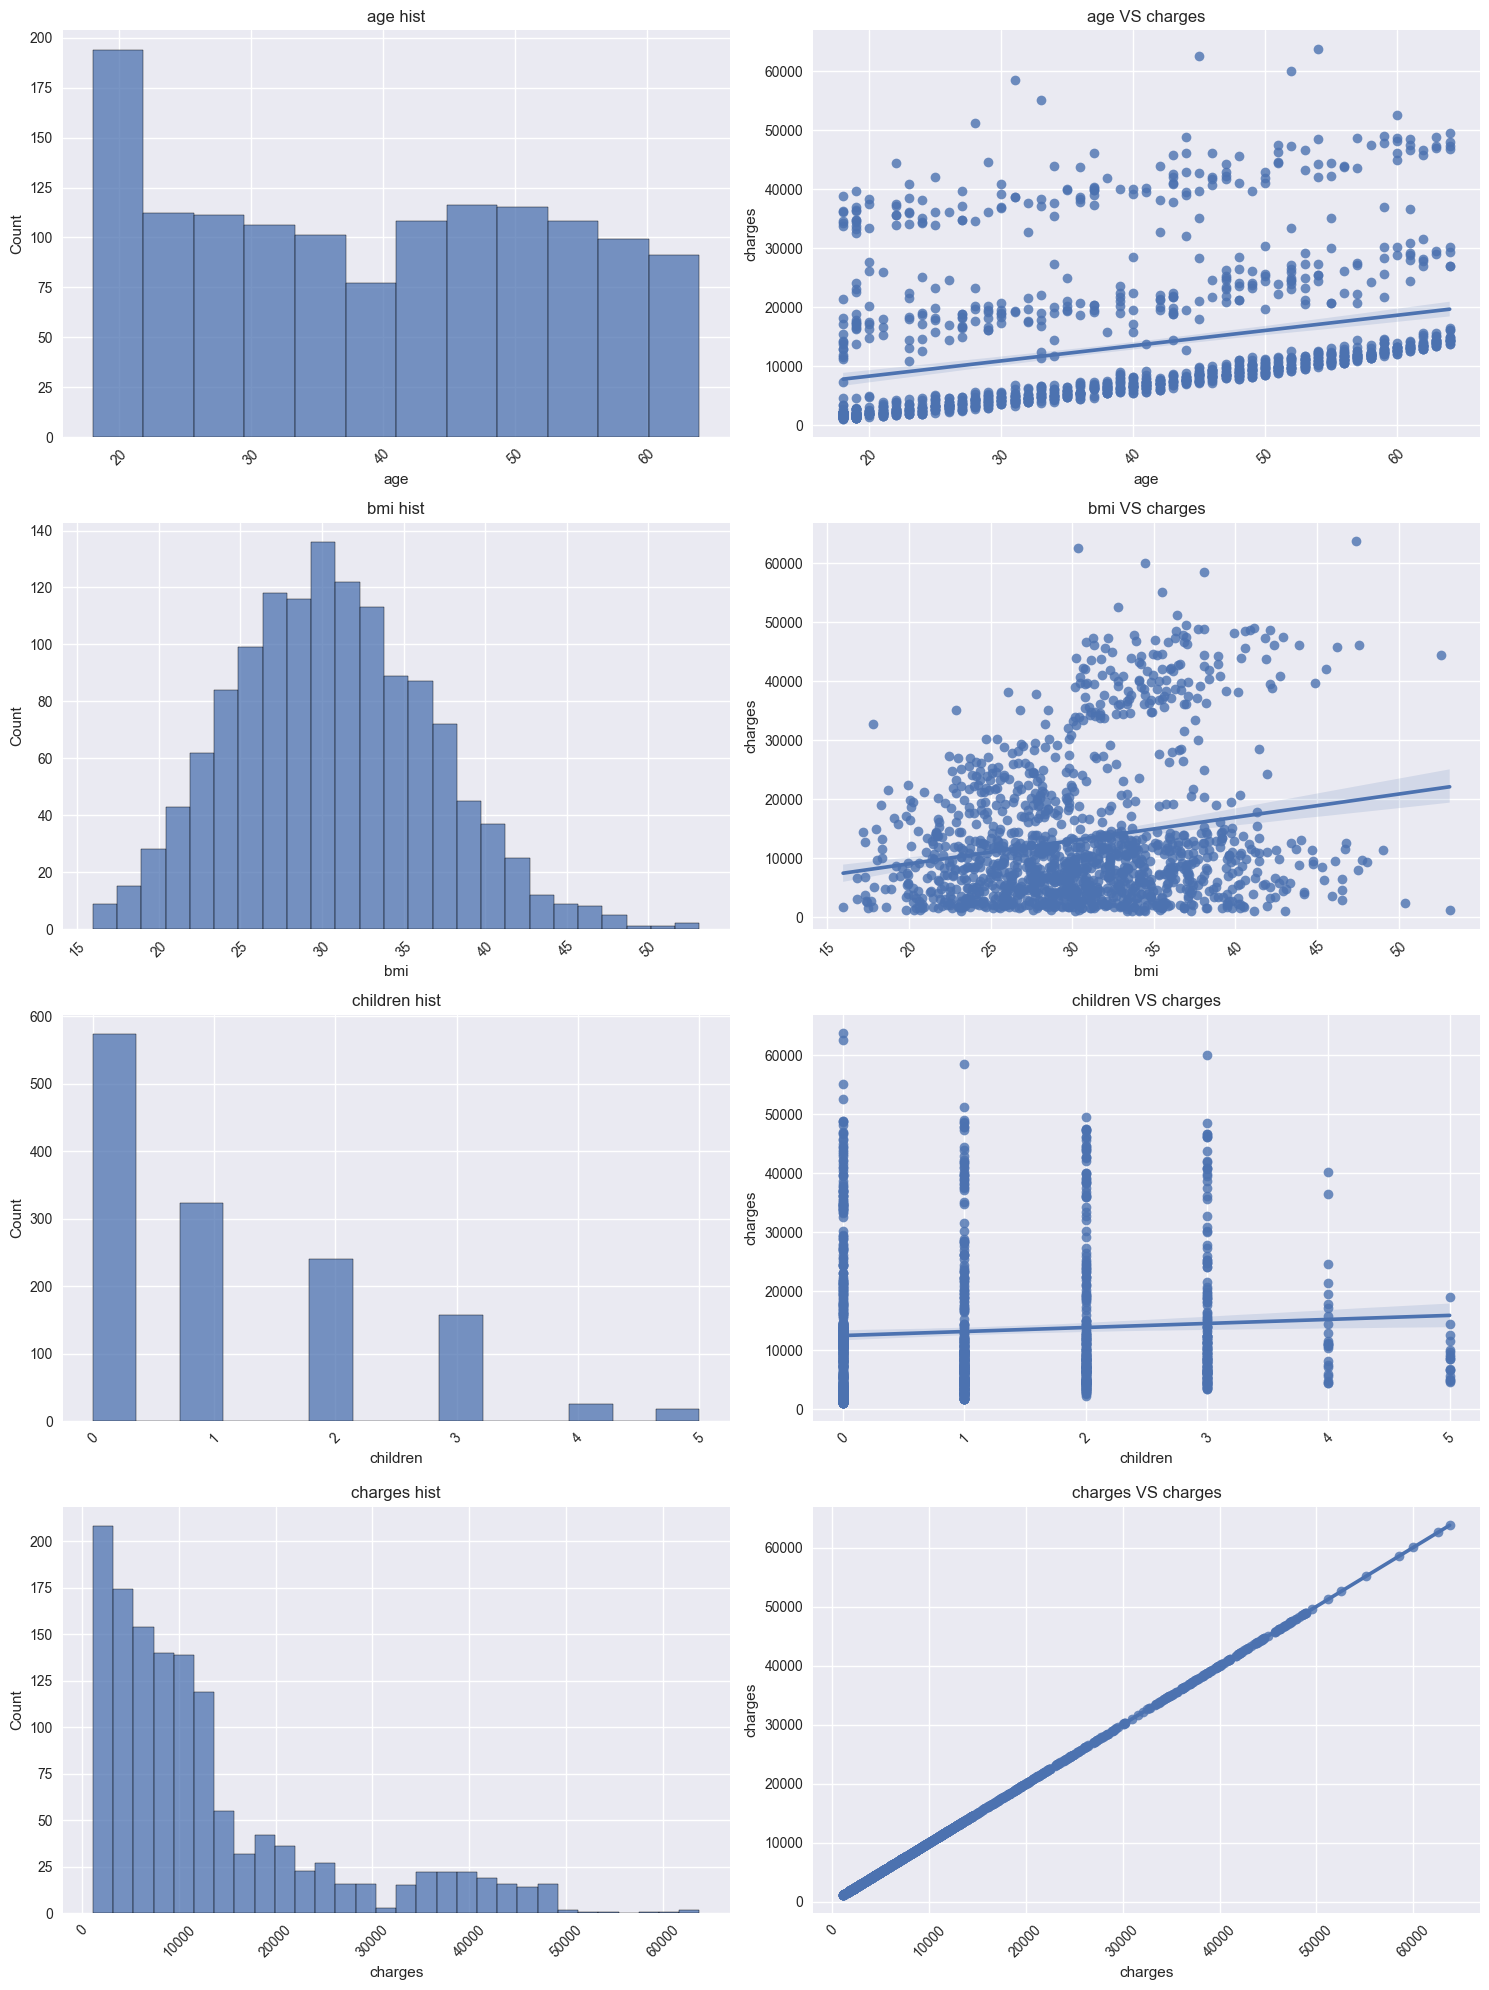

In [150]:
n = len(num_features) # количество числовых признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 20)) # фигура + n х 2 координатных плоскостей
# Создаем цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(num_features): #i- индекс, feature - название признака в таблице
    # Строим гистограмму распределения признака 
    histplot = sns.histplot(data=temp_data, x=feature, ax=axes[i][0])
    # Добавляем подпись графику
    histplot.set_title('{} hist'.format(feature))
    # Добавляем поворот отметок на оси абсцисс
    histplot.xaxis.set_tick_params(rotation=45)
    # Строим диаграмму рассеяния + линейную регрессию
    regplot = sns.regplot(data=temp_data, x=feature, y='charges', ax=axes[i][1])
    # Добавляем подпись графику
    regplot.set_title('{} VS charges'.format(feature));
    # Добавляем поворот отметок на оси абсцисс
    regplot.xaxis.set_tick_params(rotation=45)
plt.tight_layout() # выравнивание графиков

Строим тепловую карту для корреляционной матрицы, чтобы оценить мультиколлинеарную зависимость и линейную взаимосвязь между факторами и целевым признаком (charges)

C:\Users\Lida\AppData\Local\Temp\ipykernel_10540\396918198.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(temp_data.corr(), annot=True);


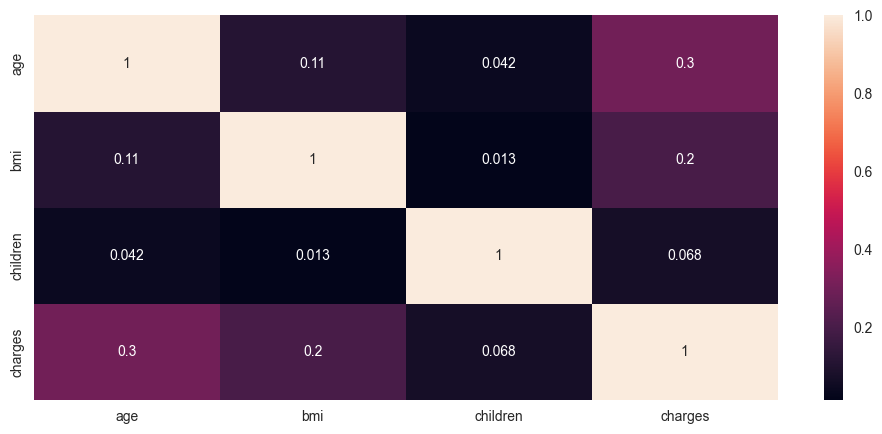

In [151]:
# строим тепловую карту корреляций
fig = plt.figure(figsize=(12, 5))
sns.heatmap(temp_data.corr(), annot=True);

Мы знаем, что модель линейной регрессии не умеет работать с категориальными признаками, поэтому категории необходимо перекодировать.

Кодировку будем совершать по следующему принципу:

* *smoker* — переведём в бинарные значения (0 — некурящий, 1 — курящий);
* *sex* — аналогично (0 — female, 1 — male);
* *region* — используем OneHot-кодирование (воспользуемся функцией get_dummies).

In [152]:
# кодируем бинарные категориальные признаки
temp_data['smoker'] = temp_data['smoker'].apply(lambda x: 0 if x == 'no' else 1)
temp_data['sex'] = temp_data['sex'].apply(lambda x: 0 if x == 'female' else 1)
# оставшиеся категориальные признаки кодируем с помощью OneHot
temp_data = pd.get_dummies(temp_data)
temp_data.head(3)

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.90,0,1,16884.9240,0,0,0,1
1,18,1,33.77,1,0,1725.5523,0,0,1,0
2,28,1,33.00,3,0,4449.4620,0,0,1,0


In [153]:
temp_data.shape

(1338, 10)

Итак, мы получили перекодированную таблицу, в которой все признаки являются числовыми.

Выделим факторы и целевой признак в отдельные таблицы:

In [154]:
features = temp_data.drop('charges', axis=1).columns
X, y = temp_data[features], temp_data['charges']

Прежде чем переходить к этапу моделирования, нам необходимо позаботиться о создании выборки для тестирования модели.

Разделим набор данных на тренировочную и тестовую выборки в соотношении 80/20. Воспользуемся функцией train_test_split.

В качестве значения параметра random_state укажем число 42.

In [155]:
# Создаем тренировочную и тестовую выборки с помощью train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, # таблица с наблюдениями и столбец с правильным ответами
    test_size=0.2, # размер тестовой выборки
    random_state=42 # число отвечающее за генерацию случайных чисел
)
# Выводим размеры полученных выборок
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1070, 9)
Test shape: (268, 9)


### Моделирование + Оценка модели

Цель этапа - построить модель, решающую поставленную задачу и оценить ее качество

Заранее создадим функцию, которая будет расчитывать метрики:

1. MAE - средняя абсолютная ошибка (целевая метрика)
2. MAPE - средняя абсолютная ошибка в процентах 
3. $R^2$ - коэффициент детерминации 

In [156]:
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.3f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))

В библиотеке sklearn линейная регрессия с поиском параметров по OLS реализована в классе LinearRegression модуля linear_model. 

Методы:
* fit() - подгонка параметров по OLS (обучение модели)
* predict() - предсказание (подстановка наблюдения $x_i$ в модель и получение ответа для каждого наблюдения)

Атрибуты:
* coef_ - найденные с помощью OLS коэффициенты $\omega_1, \omega_2,$ ...,$ \omega_m$ (в виде вектора)
* intercept_ - свободный член $\omega_0$

In [157]:
# Инициализируем объект класса линейная регрессия
lr = linear_model.LinearRegression()
# Обучаем модель - ищем параметры
lr.fit(X_train, y_train)
# Делаем предсказание для каждой из выборок
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
# Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.742
Train MAE: 4208.235
Train MAPE: 42.203


Test R^2: 0.784
Test MAE: 4181.194
Train MAPE: 46.888


Чему равен свободный член (intercept) обученной модели? Ответ округлите до сотых.

In [158]:
print(np.round(lr.intercept_, 2))

-12390.8


Посмотрим на разброс ошибок нашей модели с помощью boxplot-диграммы. Это поможет нам понять, как много автомобилей в каждой из выборок, для которых мы допускаем высокую ошибку в предсказании целевого призака.

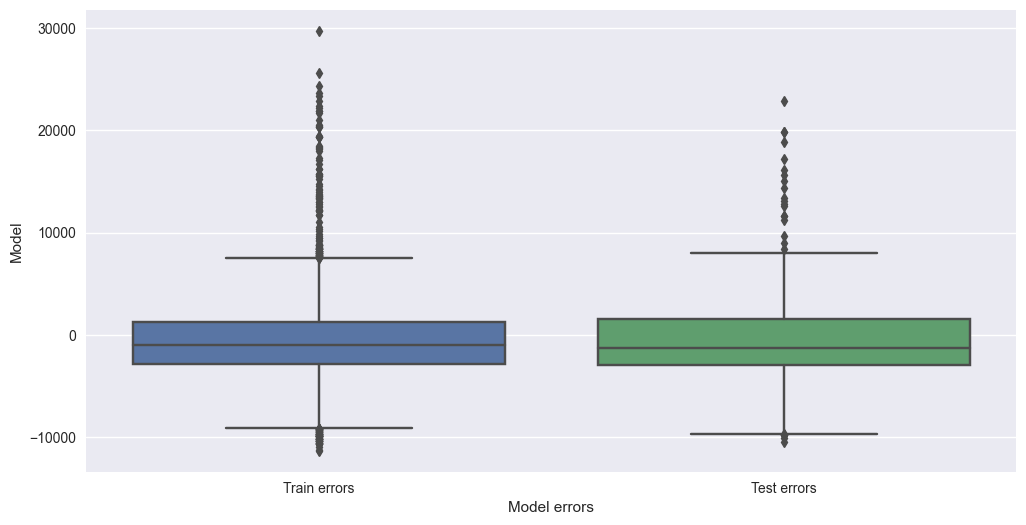

In [159]:
# Визуализируем ошибки
fig, ax = plt.subplots(figsize=(12, 6)) #фигура+координатная плоскость
# Ошибки модели на тренировочной выборке 
y_train_errors = y_train - y_train_pred
# Ошибки модели на тестовой выборке
y_test_errors = y_test - y_test_pred
# Для удобства визуализации составим DataFrame из ошибок
predict_df = pd.DataFrame(
    {'Train errors': y_train_errors, 
     'Test errors': y_test_errors
    }
)
# Строим boxplot для ошибок
sns.boxplot(data=predict_df, ax=ax)
ax.set_xlabel('Model errors') # название оси абсцисс
ax.set_ylabel('Model'); # название оси ординат

Попробуем добавить в данные полиномиальные признаки и построить модель полиномиальной регрессии. Предварительно нормализуем данные:

In [160]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaled)
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)
print(X_train_scaled_poly.shape)

(1070, 54)


In [161]:
lr_poly = linear_model.LinearRegression()
lr_poly.fit(X_train_scaled_poly, y_train)

y_train_predict = lr_poly.predict(X_train_scaled_poly)
y_test_predict = lr_poly.predict(X_test_scaled_poly)
print_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.842
Train MAE: 2912.958
Train MAPE: 29.808


Test R^2: 0.866
Test MAE: 2762.470
Train MAPE: 30.738


In [162]:
print(lr_poly.coef_)

[-3.71105135e+16  2.90624807e+17 -7.81502356e+15  1.52571599e+15
 -8.85674845e+15 -2.58845363e+16 -1.77612957e+17 -7.20024939e+16
 -4.46806128e+16  8.44000000e+03  8.42000000e+02  9.18000000e+02
 -1.82200000e+03  2.52000000e+02  3.71105135e+16  3.71105135e+16
  3.71105135e+16  3.71105135e+16 -2.48025958e+17  7.83250000e+02
 -1.32012500e+03  3.07250000e+02 -4.25988491e+16 -4.25988491e+16
 -4.25988491e+16 -4.25988491e+16 -9.52918750e+03  1.69346875e+03
  5.48946094e+04  7.81502356e+15  7.81502356e+15  7.81502356e+15
  7.81502356e+15 -2.08000000e+03 -2.25400000e+03 -1.52571599e+15
 -1.52571599e+15 -1.52571599e+15 -1.52571599e+15 -2.35115674e+16
  3.23683159e+16  3.23683159e+16  3.23683159e+16  3.23683159e+16
 -3.73724177e+16  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.14356003e+17  0.00000000e+00  0.00000000e+00  8.74553994e+15
  0.00000000e+00 -1.85763413e+16]


In [166]:
lasso_lr_poly = linear_model.Lasso(max_iter=2000)
lasso_lr_poly.fit(X_train_scaled_poly, y_train)

y_train_predict = lasso_lr_poly.predict(X_train_scaled_poly)
y_test_predict = lasso_lr_poly.predict(X_test_scaled_poly)

print_metrics(y_train, y_train_predict, y_test, y_test_predict)

#print(lasso_lr_poly.coef_)

Train R^2: 0.842
Train MAE: 2890.473
Train MAPE: 29.401


Test R^2: 0.867
Test MAE: 2719.334
Train MAPE: 30.070


In [164]:
ridge_lr_poly = linear_model.Ridge()
ridge_lr_poly.fit(X_train_scaled_poly, y_train)

y_train_predict = ridge_lr_poly.predict(X_train_scaled_poly)
y_test_predict = ridge_lr_poly.predict(X_test_scaled_poly)

print_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.839
Train MAE: 2948.804
Train MAPE: 29.546


Test R^2: 0.863
Test MAE: 2860.555
Train MAPE: 31.380
